## MMC-DRC Refugee Returnee Analysis – Afghanistan

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
sys.path.append('../scripts')
# from utils import demo

In [10]:
# load the CEI dataset
data_file_path = '../data/afghan_returnee_dataset_24_03_2025.xlsx'
data = pd.read_excel(data_file_path)

### Understanding Data Structure

In [11]:
print("Dataset loaded successfully. Here are the first few rows:")
data.head()

Dataset loaded successfully. Here are the first few rows:


,today,username,"Do you understand all the information we just gave you, and do you agree to continue?",[Enumerator: How many people refused to be interviewed before this interview?],Have you been interviewed in Afghanistan by the Mixed Migration Centre before?,Do you feel comfortable answering my questions at this time or do you want me to call another time?,[Enumerator: Do you feel you are undisturbed or other people are able to hear our conversation?],Who is present and listening?,Q16/Other migrants,Q16/Spouse,...,Q162/Technical / connection problems,Q162/None,Q162/Other,Please specify45,audit,instanceID,_id,_uuid,_submission_time,_submitted_by
0,2025-03-09 00:00:00,asia_afg24,Yes,1,No,Yes,Undisturbed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,audit.csv,uuid:88332d5a-4fa2-4634-8552-e4ee5d15bec7,167802629,88332d5a-4fa2-4634-8552-e4ee5d15bec7,2025-03-09 09:04:38,asia_afg24
1,2025-03-09 00:00:00,asia_afg24,Yes,1,No,Yes,Undisturbed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,audit.csv,uuid:017f3ebb-0d65-478b-8cb8-6d5e085148ef,167802630,017f3ebb-0d65-478b-8cb8-6d5e085148ef,2025-03-09 09:04:40,asia_afg24
2,2025-03-09 00:00:00,asia_afg24,Yes,0,No,Yes,Undisturbed,NaN,NaN,NaN,...,Technical / connection problems,NaN,NaN,NaN,audit.csv,uuid:bd2c509a-abbd-4db7-9391-ce731d3cb612,167802631,bd2c509a-abbd-4db7-9391-ce731d3cb612,2025-03-09 09:04:42,asia_afg24
3,2025-03-09 00:00:00,asia_afg24,Yes,1,No,Yes,Undisturbed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,audit.csv,uuid:bd0b35cb-42d7-4773-9f6d-6e3acb4b21a1,167802632,bd0b35cb-42d7-4773-9f6d-6e3acb4b21a1,2025-03-09 09:04:43,asia_afg24
4,2025-03-09 00:00:00,asia_afg24,Yes,1,No,Yes,Undisturbed,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,audit.csv,uuid:989765d0-e839-4d98-a495-eaf41bc56dec,167802634,989765d0-e839-4d98-a495-eaf41bc56dec,2025-03-09 09:04:45,asia_afg24


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Columns: 555 entries, [Enumerator: How many people refused to be interviewed before this interview?] to Please specify45
dtypes: float64(128), int64(3), object(424)
memory usage: 3.1+ MB


### 2. Summary Statistics

In [ ]:
# distribution of numerical columns
pd.DataFrame(data.describe()).T

,count,unique,top,freq
Q5,741,2,Yes,740
Q2,741,5,0,624
Q3,741,2,No,740
Q7,741,2,Yes,740
Q15,741,3,Undisturbed,671
...,...,...,...,...
Q162/Respondent didn't understand some questions,82,2,Respondent didn't understand some questions,81
Q162/Technical / connection problems,204,2,Technical / connection problems,203
Q162/None,1,1,Q162/None,1
Q162/Other,1,1,Q162/Other,1


### 3. Data Cleaning
- Removing not neccessary columns
- Handling missing values, invalid data, etc.

In [14]:
# List of all columns to drop
columns_to_drop = [
    'audit',
    'instanceID',
    '_id',
    '_uuid',
    '_submission_time',
    '_submitted_by',
    'today',
    'username',
    'Do you understand all the information we just gave you, and do you agree to continue?'
]

# Drop columns only if they exist in the dataset
df = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

In [18]:
# check columns with missing values
nul_cols = df.isnull().sum()
nul_cols = nul_cols[nul_cols > 0].sort_values(ascending=False)

print(nul_cols)

Please specify45                                                                                                                                           740
R27_2/Other                                                                                                                                                740
Please specify13                                                                                                                                           740
R56/Other                                                                                                                                                  740
R67/Other                                                                                                                                                  740
                                                                                                                                                          ... 
Before return, what were your sources of infor

In [19]:
# Remove the columns with no values
df = df.dropna(axis=1, how='all')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Columns: 428 entries, [Enumerator: How many people refused to be interviewed before this interview?] to Q162/Technical / connection problems
dtypes: float64(1), int64(3), object(424)
memory usage: 2.4+ MB


### 4. Data Distribution

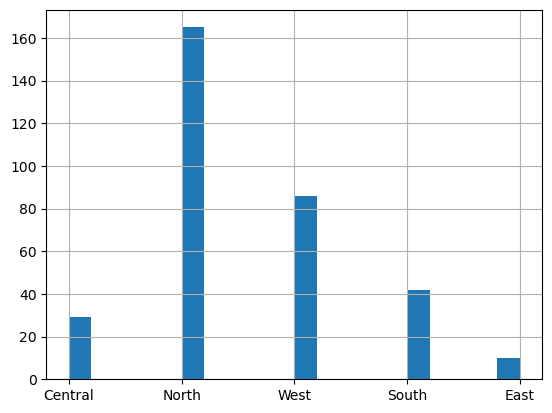

In [31]:
# Histogram: Data distribution across regions
data['REGION'].hist(bins=20)
plt.show()


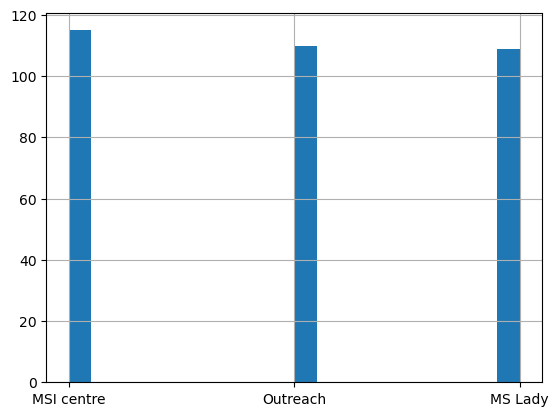

In [7]:
# Data distribution across channels
data['FACTYPE'].hist(bins=20)
plt.show()

### 5. Correlation Analysis
- Correlation matrix: To identify correlations between numerical variables

In [32]:
numerical_cols = data.select_dtypes(include=['number']).columns.drop(['_id', '_index','id'])

correlation_matrix = data[numerical_cols].corr()
correlation_matrix

,TR2DH,TR2DM,PAINOP_IMPREM,PAINSCALE_DREM,PAINSCALE_AREM,CMAUTO,PAINSCALE_DCM,PAINSCALE_ACM,AGE,CHILD,...,lo_educ,lo_elct,lo_wtr,lo_sani,lo_hsg,lo_ckfl,lo_asst,lompiscore,mpi_sevpoor,pillar1
TR2DH,1.000000,0.265805,-0.250000,0.007459,0.127046,0.138172,-0.036633,-0.053733,-0.050062,-0.039636,...,0.022185,0.054582,0.145154,-0.083482,0.077769,0.117822,0.076495,0.011440,0.030201,0.260538
TR2DM,0.265805,1.000000,0.750000,0.273928,0.415064,-0.047749,0.202383,0.343889,0.049628,0.063720,...,-0.018137,0.094527,-0.086813,-0.293280,-0.168897,0.012934,-0.048124,-0.147028,-0.099986,0.234891
PAINOP_IMPREM,-0.250000,0.750000,1.000000,0.490290,0.731272,0.391630,NaN,NaN,-0.425017,-0.304997,...,0.188982,0.188982,NaN,-0.632456,-0.377964,-0.250000,-0.250000,0.178571,NaN,-0.250000
PAINSCALE_DREM,0.007459,0.273928,0.490290,1.000000,0.886619,0.226555,NaN,NaN,0.216701,0.426944,...,-0.149516,0.213720,-0.092265,-0.293267,-0.385806,-0.285885,0.011961,-0.287559,-0.189957,-0.350263
PAINSCALE_AREM,0.127046,0.415064,0.731272,0.886619,1.000000,0.329358,NaN,NaN,0.184229,0.364070,...,0.030718,0.351745,-0.221512,-0.411721,-0.280252,-0.085791,0.054688,-0.085126,-0.221512,-0.235843
CMAUTO,0.138172,-0.047749,0.391630,0.226555,0.329358,1.000000,-0.015110,-0.029976,0.025988,-0.063475,...,-0.113591,0.028528,0.124842,-0.121111,0.067663,0.020031,0.072372,0.018157,0.000999,0.155963
PAINSCALE_DCM,-0.036633,0.202383,NaN,NaN,NaN,-0.015110,1.000000,0.697271,0.079196,0.147840,...,-0.182798,0.170717,-0.076342,-0.206253,0.202145,0.004229,0.049557,-0.202951,-0.072747,-0.039183
PAINSCALE_ACM,-0.053733,0.343889,NaN,NaN,NaN,-0.029976,0.697271,1.000000,0.094373,0.134087,...,-0.181314,0.225128,-0.169326,-0.294924,0.132602,-0.018264,0.111070,-0.174287,-0.038910,-0.045979
AGE,-0.050062,0.049628,-0.425017,0.216701,0.184229,0.025988,0.079196,0.094373,1.000000,0.735082,...,-0.124986,-0.060712,0.060149,-0.052677,0.132235,0.002937,0.004764,-0.110027,-0.062671,0.040576
CHILD,-0.039636,0.063720,-0.304997,0.426944,0.364070,-0.063475,0.147840,0.134087,0.735082,1.000000,...,-0.152900,0.138493,0.100677,-0.036311,0.194998,0.091450,0.095811,-0.088693,-0.022765,0.017784


### 6. Save the Processed Data

In [33]:
data.to_csv('../data/processed/MSIA_2024_CEI_Afghanistan_data_cleaned.csv', index=False)